In [82]:
import pandas as pd
import gdown
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# file_id = "1gPd7ginXt7jq0Ef4ZZvLCXBuAAWEu7wA"       
# # Para saber esto cojo el link entero -> https://drive.google.com/file/d/1gPd7ginXt7jq0Ef4ZZvLCXBuAAWEu7wA/view?usp=sharing y corto para tener solo la parte de id (entre /d/ y /view?)
# download_url = f'https://drive.google.com/uc?id={file_id}'
output = '../datos_amazon.csv'
# gdown.download(download_url, output, quiet=False)

## LAS COSAS CON COMENTS SOLO UNA VEZ PARA DESCARGARLO AL PC


df_amazon = pd.read_csv(output)

In [83]:
# 1.1.a) Create a crosstab between the product category and the isBestSeller status.

crosstab_result = pd.crosstab(df_amazon['category'], df_amazon['isBestSeller'])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [84]:
# 1.1.b) Are there categories where being a best-seller is more prevalent?

prevalent_cat = {}

for x in range(len(crosstab_result)):
    prevalent_cat[crosstab_result.index[x]] = 100*crosstab_result.values[x][1] / (crosstab_result.values[x][1]+ crosstab_result.values[x][0])       # Percent of best_seller in each category

prevalent_cat_ordered = sorted(prevalent_cat.items(), key=lambda x : x[1], reverse=True)

prevalent_cat_ordered[:5]

[('Grocery', 5.8134671685487245),
 ('Smart Home Security & Lighting', 5.769230769230769),
 ('Health & Personal Care', 5.7686278608005015),
 ('Mobile Phone Accessories', 4.2471042471042475),
 ('Power & Hand Tools', 3.533895368980252)]

In [85]:
# 1.2.a) Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)
# Las _ las pongo porque en Python, cuando se asignan valores a variables en una línea, pero no se necesita utilizar todos los valores, se pueden utilizar guiones bajos (_) como "variables de descarte" 
# para ignorar los valores que no se necesitan.
# Las _, _ representarian los gdl y la tabla de frecuencias esperada. Los grados de libertad no corresponden con los de Cramer, cuidado.

print(f"""
The chi^2 statistic value is {chi2_statistic}               
The chi^2 p value is {chi2_p_value}
      """)


# En si mismo el chi2_statistic no nos dice nada y podriamos poner _ en su argumento igual que lo hacemos con los otros 2 parámetros


The chi^2 statistic value is 36540.20270061387               
The chi^2 p value is 0.0
      


*H0* = There is no association between 'category and 'isBestSeller'     --- Null Hypothesis p>=0.05
*H1* = There is an association between 'category and 'isBestSeller'     --- Alternative Hypothesis p<0.05

Our chi^2 p value es 0.0 so we refuse H0 and conclude that there is an association between 'category and 'isBestSeller'

In [86]:
# 1.2.b) Compute Cramér's V to understand the strength of association between best-seller status and category.
from scipy.stats.contingency import association

association(crosstab_result, method="cramer")

# crosstab_result.shape -> 296, 2. -> Cojo el num de filas o columnas (el valor más pequeño y resto 1) 2-1 = Tengo 1 grado de libertad

# In the Cramer's V table, the value 0.12 in row 1 would fall under the "small" column, indicating a weak correlation between the columns 'category' and 'isBestSeller'.

0.1222829439760564

<Axes: xlabel='category'>

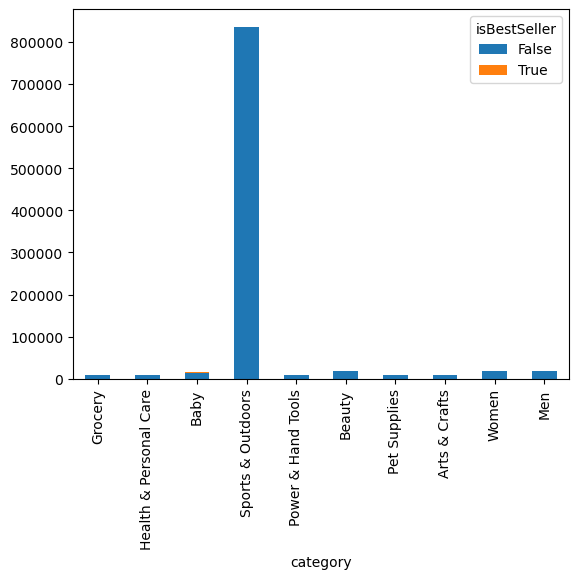

In [87]:
# 1.3) Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

top_best_seller = crosstab_result.sort_values(by=True, ascending=False)[:10]
top_best_seller.plot(kind="bar", stacked=True)       # Muestra los 10 primeros.

# crosstab_result.plot(kind="bar", stacked=True, figsize=(120,80))  -> Para verlo bien aunque muestre todo y siga siendo meh

In [88]:
# 2.0) Remove outliers in product prices.
Q1 = df_amazon["price"].quantile(0.25)
Q3 = df_amazon["price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

lower_bound, upper_bound
# We are talking about prices so our lower bound can´t be negative, it must be 0 instead.

outliers = df_amazon[["price"]][(df_amazon["price"] < lower_bound) | (df_amazon["price"] > upper_bound)]        # df con los outliers

df_amazon = df_amazon[~df_amazon['price'].isin(outliers['price'])]       # ~ es la negación en Python
df_amazon.reset_index(drop=True, inplace=True)


In [89]:
lower_bound, upper_bound

(-44.01, 99.99000000000001)

C:\Users\Iván\AppData\Local\Temp\ipykernel_4908\2318240016.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_20, x="category", y="price", palette="Set2")


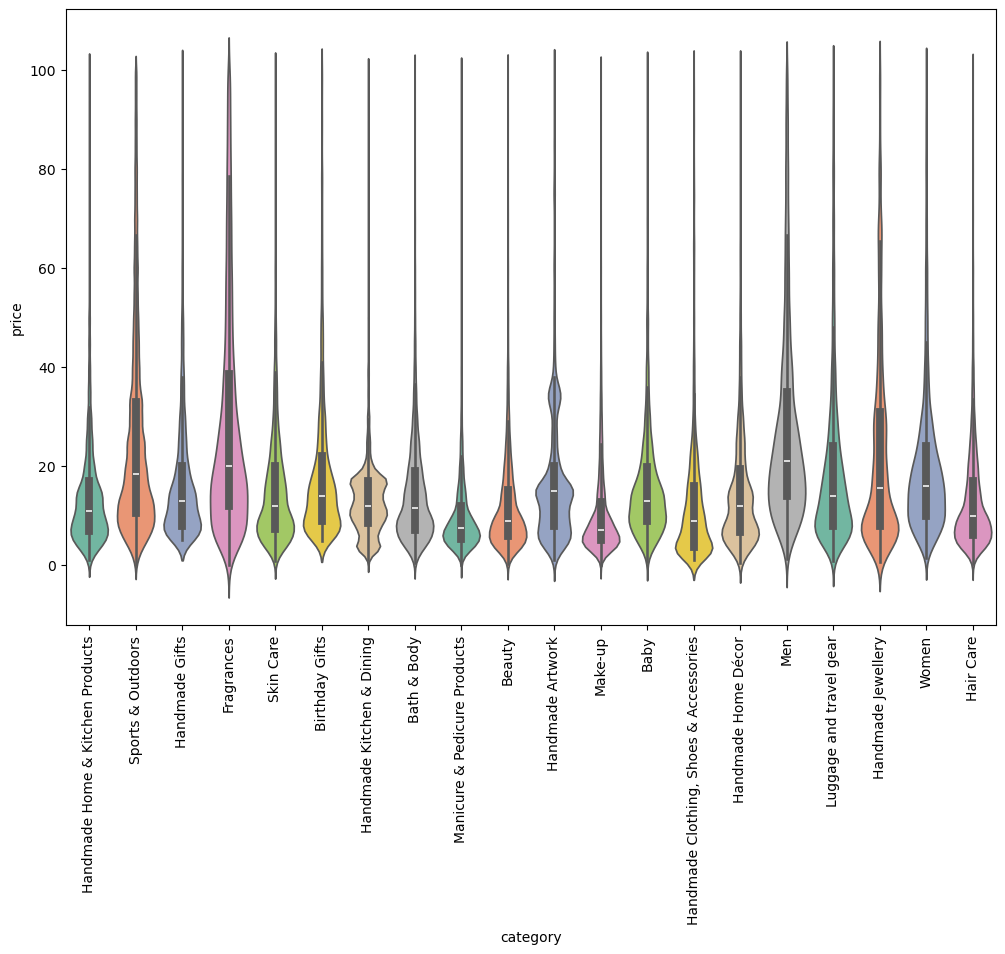

In [90]:
# 2.1.a) Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.

cat_counts_20 = df_amazon["category"].value_counts().head(20).index
df_top_20 = df_amazon[df_amazon['category'].isin(cat_counts_20)]

plt.figure(figsize=(12,8))
sns.violinplot(data=df_top_20, x="category", y="price", palette="Set2")
plt.xticks(rotation=90)
plt.show()


In [91]:
# 2.1.b) Which product category tends to have the highest median price? Don't filter here by top categories.

df_amazon[["category", "price"]].groupby("category").median().sort_values(by="price", ascending=False).head(1)

,price
category,
Desktop PCs,74.0


<Axes: xlabel='category'>

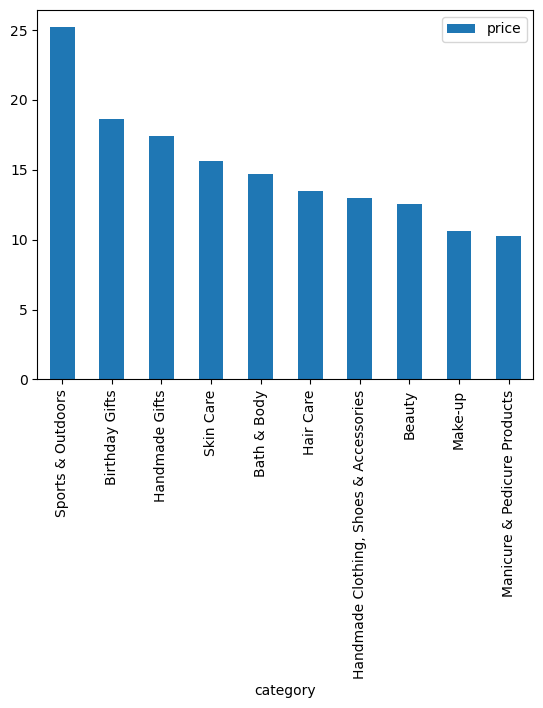

In [92]:
# 2.2.a) Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

cat_counts_10 = df_amazon["category"].value_counts().head(10).index
df_top_10 = df_amazon[df_amazon['category'].isin(cat_counts_10)]


df_top_10_grouped = df_top_10[["category", "price"]].groupby("category").mean().sort_values(by="price", ascending=False).head(10)

df_top_10_grouped.plot(kind="bar")

In [93]:
# 2.2.b) Which product category commands the highest average price? Don't filter here by top categories.

df_amazon[["category", "price"]].groupby("category").mean().sort_values(by="price", ascending=False).head(1)

,price
category,
Motherboards,68.772432


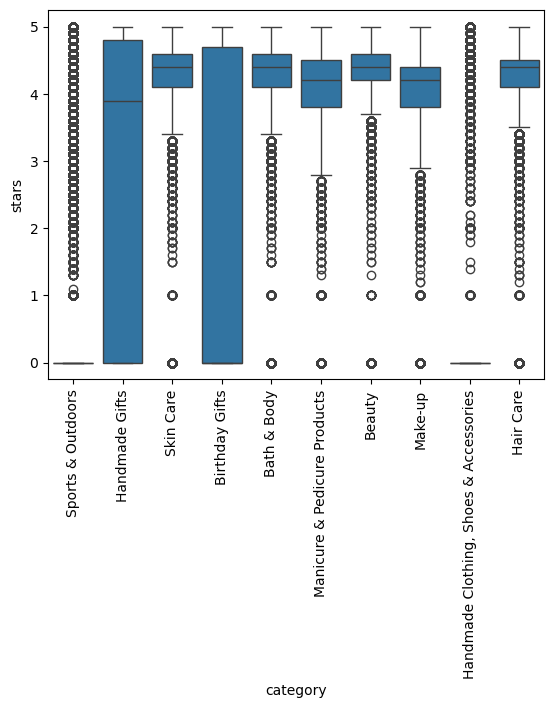

In [94]:
# 2.3.a) Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

cat_counts_10 = df_amazon["category"].value_counts().head(10).index

sns.boxplot(data=df_amazon[df_amazon['category'].isin(cat_counts_10)], x="category", y="stars")
plt.xticks(rotation=90)
plt.show()

In [95]:
# 2.3.b) Which product category commands the highest average rating? Don't filter here by top categories.

df_amazon[["category", "stars"]].groupby("category").mean().sort_values(by="stars", ascending=False).head(1)

,stars
category,
Luxury Food & Drink,4.54414


In [96]:
# 3.1.a) Calculate the correlation coefficient between price and stars.

df_amazon["stars"].corr(df_amazon["price"])

-0.0776729987818137

3.1.b) Is there a significant correlation between product price and its rating?

Yes, there is: We have a value of -0.078... which means:  
        - value < 0 There is a negative correlation, meaning that as price increases, stars decreases.  
        - value near to 0 -> The correlation is weak

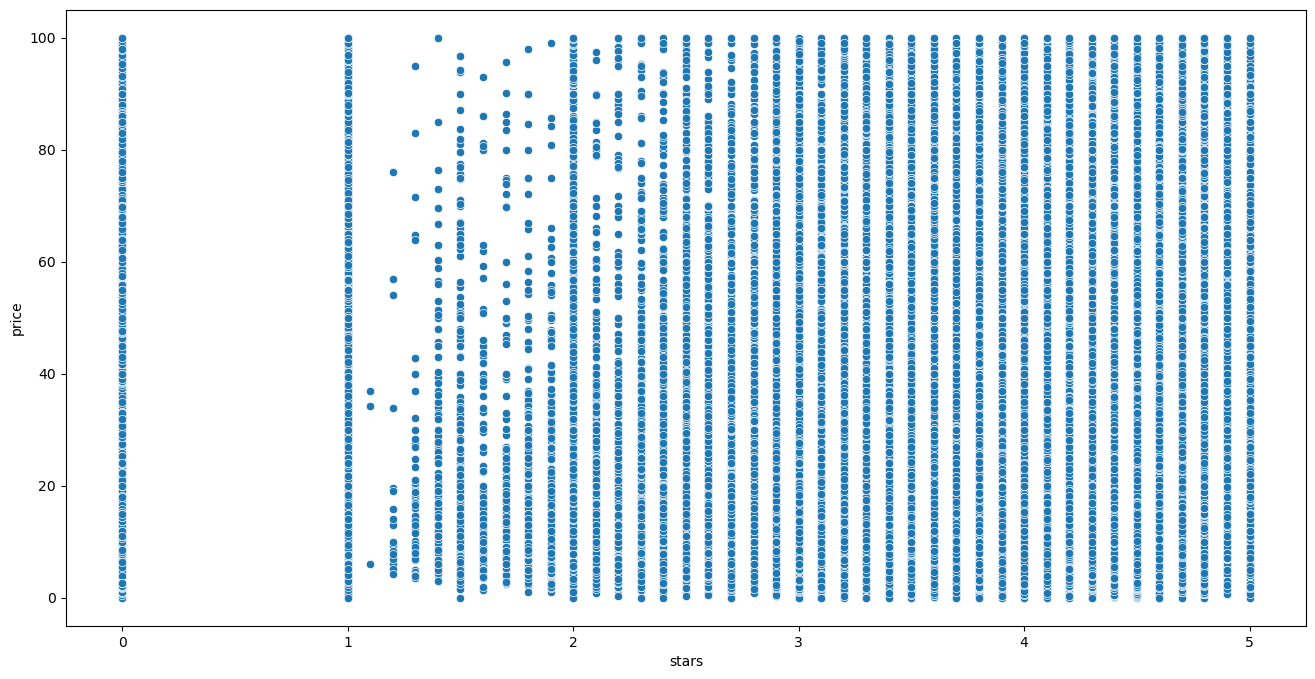

In [106]:
# 3.2.a) Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

plt.figure(figsize=(16,8))
sns.scatterplot(data=df_amazon, x='stars', y='price');


# There are not only one rate values are between 0 and 1
# Products above ~40 $ have more prob of being rated with more stars

<Axes: >

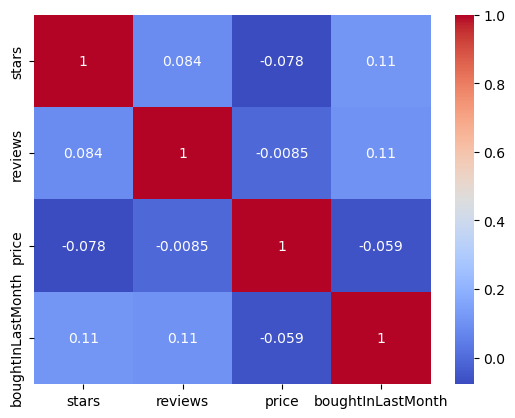

In [98]:
# 3.2.b) Use a correlation heatmap to visualize correlations between all numerical variables.

df_amazon_num = df_amazon[['stars', 'reviews', 'price', 'boughtInLastMonth']]

corr_matrix = df_amazon_num.corr(method='spearman')              # Por defecto es Pearson, pero puedo poner otros -> .corr(method='spearman')   

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

In [99]:
# ALT con Spearman

spearman_corr = df_amazon_num.corrwith(df_amazon_num['stars'], method='spearman')

spearman_corr

stars                1.000000
reviews              0.834119
price               -0.066797
boughtInLastMonth    0.300231
dtype: float64

<Axes: >

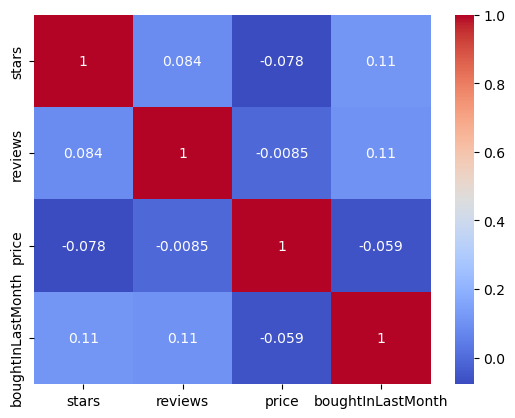

In [100]:
# Cont de ALT con Spearman

correlation_matrix = df_amazon_num[spearman_corr.index].corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

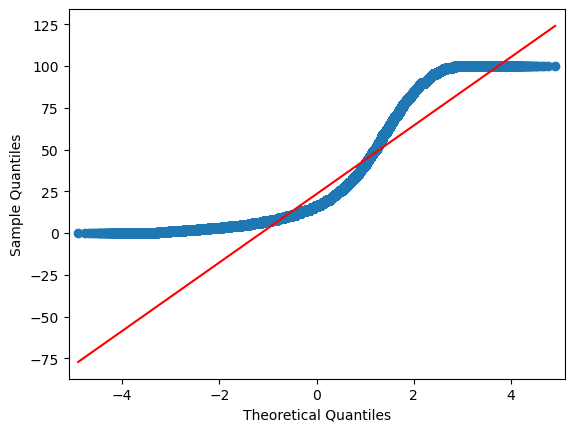

In [101]:
# 3.2.c) Examine if product prices typically follow a normal distribution using a QQ plot.
import statsmodels.api as sm

sm.qqplot(df_amazon['price'], line='s');

Los puntos en los extremos superior e inferior se desvían significativamente de la línea roja, lo que indica que la distribución de los datos tiene colas más gruesas que una distribución normal -> presencia de valores extremos o outliers

La distribución de los datos es en forma de S lo que muestra claramente que no es una distribución normal.

La curva en el centro de tu gráfico sugiere que los datos no son simétricos y podrían tener una distribución sesgada.
